<a href="https://colab.research.google.com/github/zeyneplacin/BrainMRI/blob/main/Uygulamal%C4%B1_Yapay_Zeka__v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kütüphaneler

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from google.colab import drive
from torch import nn
from torchsummary import summary
from time import time

Google Drive bağlantısını sağlıyor.

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


Drive'daki verilerin adresi

In [3]:
data_path = './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset'
tumor_path = data_path + '/Tumor'
normal_path = data_path + '/Normal'

Test
Drive'daki dosyaları görebiliyor mu?

In [4]:
os.listdir(data_path)


['readme.txt', 'Tumor', 'Normal']

Test
Tümör ve Normal olan dosyaların uzantılarını görebiliyor mu?

In [ ]:
os.listdir(tumor_path)
os.listdir(normal_path)

## veri setini oluşturma. yukarıda alınan pathlerden veri seti hazırlanıyor. Her iki sınıftaki veriler bir araya getiriliyor.

In [6]:
from genericpath import isfile
class BrainDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        #store filenames
        labls = os.listdir(data_dir)
        print (labls) #data_dir altindaki dizin isimleri
        self.labelnames = [] # data_dir içerisindeki etiket listesi, distinct olarak tutuluyor.


        self.filenames = [] #bulunan her bir görüntünün adresi tutuluyor örn: './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset/Tumor/img226.jpg'

        for f in labls:
          basedir = os.path.join(data_dir, f) #basedir = data_dir ve alt dizinin birlesmis hali
          if os.path.isfile(basedir):
            pass #readme.txt okunmadan atlanıyor.
          else:
            self.labelnames.append(f)
            print ("basedir=", basedir)
            images = os.listdir(basedir) #basedir altindaki resimlerin listesi
            print (images)
            fnames = [os.path.join(basedir, im) for im in images] #resimlerin tam dizinli dosya ismi
            self.filenames.extend(fnames)
            print('dosya isimleri: ', self.filenames)
            print ('dosya sayısı: ', len(self.filenames))

        print('etiketler: ', self.labelnames)
        #etiketler dosya isminden aliniyor
        self.labels = [filename.split('/')[-2] for filename in self.filenames] #bulunan her bir görüntünün sırasıyla etiketlerini tutuyor.
        print ("labels:", self.labels)
        self.transform = transform

    def __len__(self):
        #goruntu listesinin boyutunu dondurur
        return len(self.filenames)

    def numberOfSamples(self):
      a= self.__len__()
      print(type(a))
      return a

    def __getitem__(self, idx):
        #goruntu aciliyor, donusum uygulaniyor ve etiketiyle birlikte donduruluyor
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        label = self.name_to_idx(self.labels[idx])

        #print ('image', type(image))
        #print ('label', type(label))
        return image, label
    def name_to_idx(self, lblname):
        return self.labelnames.index(lblname)
    def idx_to_name(self, lblidx):
        return self.labelnames[lblidx]

pytorchlar tensorlarla çalıştığı için görüntüyü tensora çevirmek gerekiyor. Bu iki satır görüntüyü tensora çeviriyor.
Veriseti sınıfında init içinde veriliyor, getitem transform sırasında kullanıyor.

In [7]:
t2img = torchvision.transforms.ToPILImage()
img2t = torchvision.transforms.ToTensor()

oluşturduğumuz veriseti sınıfına Drive'dan aldığımız adresini gönderiyoruz, bir de görüntülere uygulanacak dönüşümleri gönderiyoruz. Verisetine yapılan pre process adımları burada yapılarak gönderiliyor.

Buradaki pre process adımları yerine doğrudan  transform=ToTensor() da kullanılabilir. Bu kullanılırken ayrıca
**img2t = torchvision.transforms.ToTensor()**
adımlarına gerek kalmayacaktı.

veri setini test ve train olarak ayırmak için **torch.utils.data.random_split(brain_dataset, [0.6, 0.2, 0.2])** kullanılıyor. 0.6, 0.2 oransal olarak verisetinin ne kadarının bölüneceğini gösteriyor. Bu durumda verisetinin %60'ı trainset olarak kullanılıyor.

ref:
https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

In [9]:
brain_dataset = BrainDataset(data_path, transform=torchvision.transforms.Compose([
          # torchvision.transforms.RandomHorizontalFlip(p=0.5),
          # torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
          # torchvision.transforms.RandomAffine(degrees=30, shear=10),
          # Resize image and normalize pixels using the provided mean and standard deviation
          # torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
          torchvision.transforms.Resize((256, 256)),
          img2t,
        ]))
print('verisetindeki veri sayısı: ', brain_dataset.numberOfSamples())

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(brain_dataset, [0.6, 0.2, 0.2])
print('train setindeki veri sayısı: ', len(train_dataset))
print('test setindeki veri sayısı: ', len(test_dataset))
print('val setindeki veri sayısı: ', len(val_dataset))

['readme.txt', 'Tumor', 'Normal']
basedir= ./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset/Tumor
['img226.jpg', 'img70.jpg', 'img4.jpg', 'img144.jpg', 'img84.jpg', 'img348.jpg', 'img35.jpg', 'img346.jpg', 'img135.jpg', 'img18.jpg', 'img134.jpg', 'img97.jpg', 'img406.jpg', 'img394.jpg', 'img200.jpg', 'img231.jpg', 'img330.jpg', 'img87.jpg', 'img0.jpg', 'img137.jpg', 'img391.jpg', 'img192.jpg', 'img297.jpg', 'img186.jpg', 'img25.jpg', 'img311.jpg', 'img333.jpg', 'img187.jpg', 'img207.jpg', 'img235.jpg', 'img204.jpg', 'img259.jpg', 'img100.jpg', 'img267.jpg', 'img131.jpg', 'img156.jpg', 'img195.jpg', 'img95.jpg', 'img141.jpg', 'img92.jpg', 'img193.jpg', 'img266.jpg', 'img105.jpg', 'img171.jpg', 'img400.jpg', 'img19.jpg', 'img396.jpg', 'img63.jpg', 'img125.jpg', 'img323.jpg', 'img24.jpg', 'img281.jpg', 'img81.jpg', 'img107.jpg', 'img13.jpg', 'img289.jpg', 'img284.jpg', 'img28.jpg', 'img293.jpg', 'img27.jpg', 'img6.jpg', 'img379.jpg

Test
Görüntüler gerçekten okundu mu?

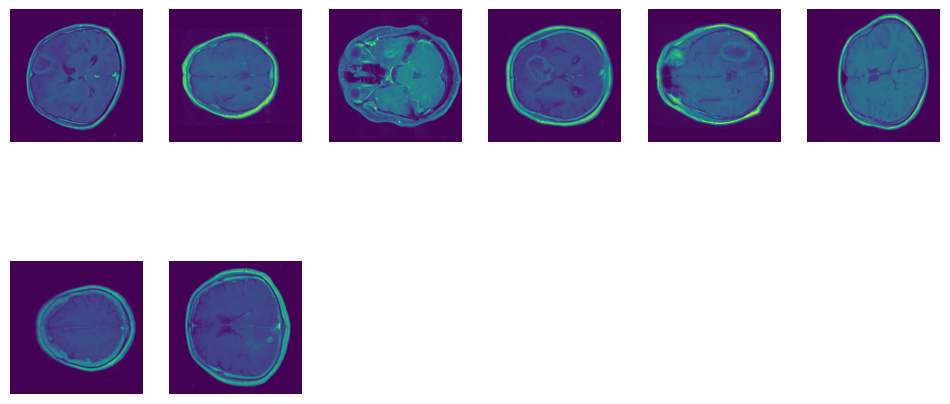

In [10]:
def display_image_grid(images, images_per_row=8):
    if isinstance(images, torch.Tensor):
        images = images.split(1, dim=0)
        images = map(lambda x: x.squeeze(0), images)
        images = list(map(t2img, images))
    elif isinstance(images, list):
        # Expect a list of PIL Images
        if isinstance(images[0], torch.Tensor):
            images = list(map(t2img, images))
        # end if
    elif isinstance(images, Image):
        images = [images]
    else:
        raise RuntimeError(f"Hata: {type(images)}")
    # end if

    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig = plt.figure(figsize=(images_per_row * 2, num_rows * 3))

    for i in range(1, num_images + 1):
        plt.subplot(num_rows, images_per_row, i)
        plt.axis("off")
        plt.imshow(images[i-1])
    # end for

    plt.show()

display_image_grid([
    train_dataset[0][0],
    train_dataset[21][0],
    train_dataset[16][0],
    train_dataset[130][0],
    train_dataset[260][0],
    train_dataset[73][0],
    train_dataset[148][0],
    train_dataset[256][0],
], 6)

Data Loader
Veri setini alıyor ve modele gönderiyor. Test ve Train olarak oluşturuyoruz.

Görüntüler gerçekten alındı mı diye test de ediliyor.

Data Loader yaratılırken Batch Size ve shuffle kullanıyor. Batch size kaç verildiyse her iterasyonda o kadar görüntü ve onların sınıfları alınıyor.


Sınıf 0: Tümör
Sınıf 1: Normal

os.listdir(data_path) adımındaki sıralamaya göre indeksleniyor.

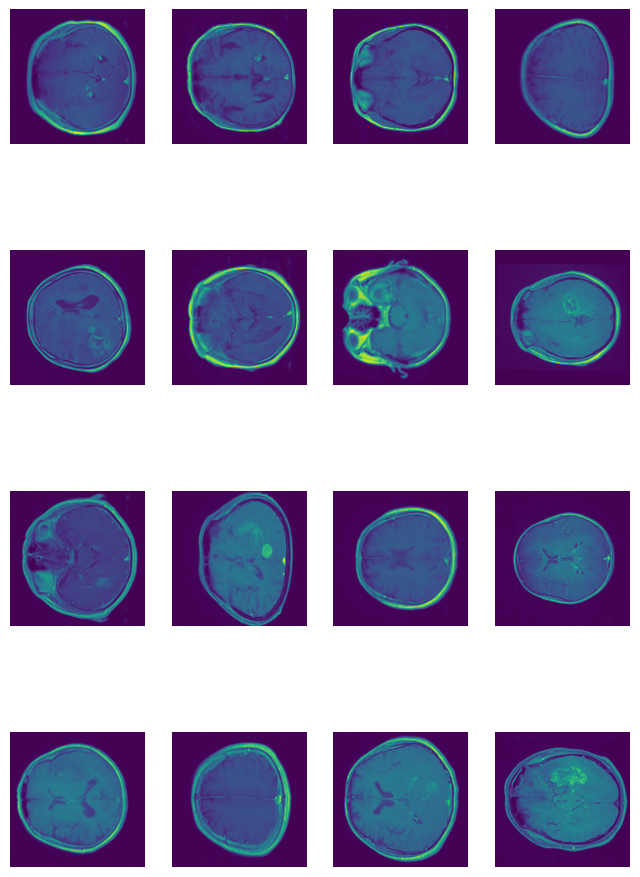

tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0])


In [11]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=16,
  shuffle=True,
)

inputs, targets = next(iter(train_loader))
display_image_grid(inputs, images_per_row=4)
print (targets)

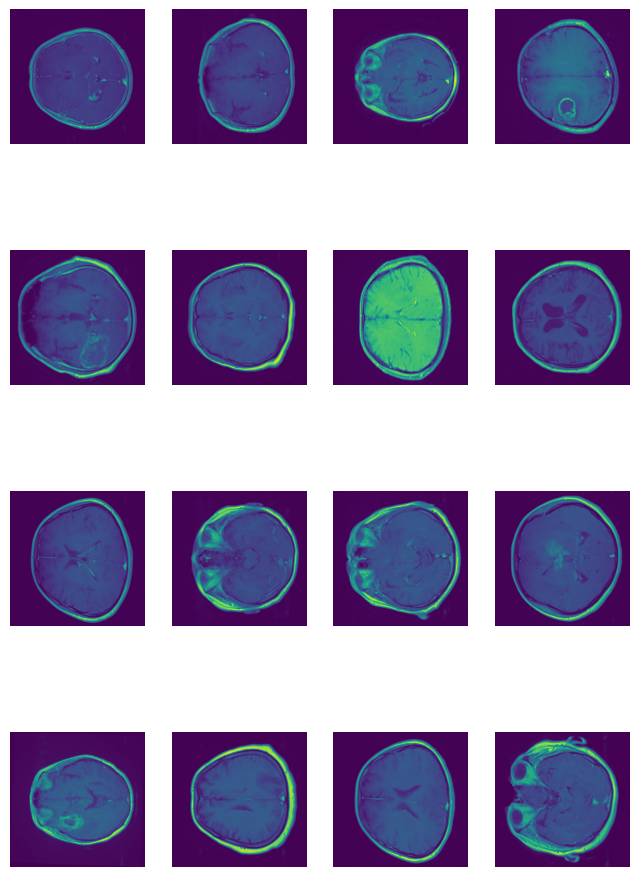

tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0])


In [12]:
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=16,
  shuffle=False,
)

inputs, targets = next(iter(test_loader))
display_image_grid(inputs, images_per_row=4)
print (targets)

# **Model Yaratma**

summary(model, (3,256,256),9)

rgb kanal sayısı: 3
girdi boyutu: 256 x 256
batch size: 9



nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),

**Layer (type)    Output Shape               Param #**
Conv2d-1        [9, 16, 254, 254]             448
ReLU-2          [9, 16, 254, 254]               0
Conv2d-3        [9, 16, 252, 252]           2,320

batch size 9 olduğu için output shape 9 ile başlıyor.
16 tane çıktı kanalı var (conv2d-1 için).
kernel size 3 olduğu için 256 x 256'lık görüntüden 2 satır 2 sütun çıkaracak şekilde 254 x 254 'lük görüntü oluşuyor.
Conv2d-2 için yine batch size 9 olduğundan 9 ile başlıyor. 16 tane output kanalı var ve 254 x 254 'lük görüntüden 252 x 252'lik görüntü oluşturuyor. (kernel nedeniyle)

conv2d-1 için parametre sayısı: 3 girdi kanalı * 16 çıktı kanalı * kernel boyutu (3*3=9) + her çıktı kanalı için 1 bias (1*16) = 448

conv2d-2 için parametre sayısı: 16 girdi kanalı * 16 çıktı kanalı * kernel boyutu (3*3=9) + her çıktı kanalı için 1 bias (1*16) = 2320

**Layer (type)             Output Shape            Param #**
MaxPool2d-25             [9, 256, 4, 4]          0
Flatten-26               [9, 4096]               0
Dropout-27               [9, 4096]               0

Flatten: batch size, 256 çıktı kanalı * 4 x 4'lük görüntünün piksel sayısı (4*4 = 16) = 4096 => 9, 4096
tüm pikselleri tek bir satıra diziyor.
Dropout: dizilen piksellerden bazılarını random olarak 0 yapıyor ve parametre olarak gönderilen p olasılık değerini 1/(1-p) formülüyle diğer piksellerin  değerlerini çarpıyor.
Bazı pikseller 0 olsa bile boyut değiştirme olmadığı için boyut: 9, 4096

(ref: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

class MRIClassifier(nn.Module):
    def __init__(self):
        super(MRIClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)

    def forward(self, x):
        #print('x boyutu: ', x.shape)
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MRIClassifier().to(device)
summary(model, (1,256,256),16)

Using: cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [9, 16, 254, 254]             160
              ReLU-2          [9, 16, 254, 254]               0
            Conv2d-3          [9, 16, 252, 252]           2,320
              ReLU-4          [9, 16, 252, 252]               0
         MaxPool2d-5          [9, 16, 126, 126]               0
            Conv2d-6          [9, 32, 124, 124]           4,640
              ReLU-7          [9, 32, 124, 124]               0
            Conv2d-8          [9, 32, 122, 122]           9,248
              ReLU-9          [9, 32, 122, 122]               0
        MaxPool2d-10            [9, 32, 61, 61]               0
           Conv2d-11            [9, 64, 59, 59]          18,496
             ReLU-12            [9, 64, 59, 59]               0
           Conv2d-13            [9, 64, 57, 57]          36,928
             ReLU-14        

In [14]:
lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Train ve Test https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12 ,den geldi.

In [15]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()

    accuracy = []

    for i, batch in enumerate(train_loader, 1):
        #print('batch-0: ', batch[0])
        #print('batch-1: ', batch[1])
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_loader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

    return total_loss / len(train_loader) # Returning Average Training Loss

In [16]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_loader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            current_acc = (target==argmax).sum().item() / target.shape[0]
            accuracy.append(current_acc) # Find the accuracy of the batch by comparing it with actual targets
            if current_acc > best_acc:
              best_acc = current_acc
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_loader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_loader) # Returning Average Testing Loss

In [17]:
train_loss = []
test_loss = []



for epoch in range(1, 21):
    print ('Epoch ', epoch)
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')

    if epoch % 10 == 0:
        fname = './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_'+str(epoch)+'.pth'
        print(fname)
        torch.save(model, fname)

Epoch  1
Epoch: [1], Test Loss: 1.7681, Accuracy: 0.54, Time: 35.30 sec


Epoch  2
Epoch: [2], Test Loss: 0.9622, Accuracy: 0.47, Time: 4.61 sec


Epoch  3
Epoch: [3], Test Loss: 0.7468, Accuracy: 0.56, Time: 5.65 sec


Epoch  4
Epoch: [4], Test Loss: 0.7487, Accuracy: 0.49, Time: 5.80 sec


Epoch  5
Epoch: [5], Test Loss: 0.7371, Accuracy: 0.54, Time: 4.41 sec


Epoch  6
Epoch: [6], Test Loss: 0.7215, Accuracy: 0.54, Time: 4.43 sec


Epoch  7
Epoch: [7], Test Loss: 0.6824, Accuracy: 0.60, Time: 4.62 sec


Epoch  8
Epoch: [8], Test Loss: 0.6993, Accuracy: 0.62, Time: 4.93 sec


Epoch  9
Epoch: [9], Test Loss: 0.7441, Accuracy: 0.52, Time: 5.47 sec


Epoch  10
Epoch: [10], Test Loss: 0.7266, Accuracy: 0.53, Time: 4.63 sec


./drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/Models/model_10.pth
Epoch  11
Epoch: [11], Test Loss: 0.7356, Accuracy: 0.51, Time: 5.65 sec


Epoch  12
Epoch: [12], Test Loss: 0.7405, Accuracy: 0.56, Time: 4.52 sec


Epoch  13
Epoch: [13], Test Loss: 0.7050,